# Hello transfer learning MobileNetV3

Perform Transfer learning on MobileNetV3 using the Fashion-MNIST dataset

In [6]:
# Prerequisites
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load the Fashion-MNIST dataset

In [4]:
def load_data_set(batch_size, data_dir="data"):
    """Load the Fashion-MNIST dataset"""

    # Define transforms to normalize data
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    # Download and load the training set
    train_set = datasets.FashionMNIST(
        data_dir, download=True, train=True, transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True
    )

    # Download and load the test set
    test_set = datasets.FashionMNIST(
        data_dir, download=True, train=False, transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=True
    )

    return train_loader, test_loader


train_loader, test_loader = load_data_set(64)

100.0%
100.0%
100.0%
100.0%


Helper functions for dealing with Fashion-MNIST labels

In [5]:
def get_class_names():
    """Return the list of classes in the Fashion-MNIST dataset."""
    return [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]


def get_class_name(class_index):
    """Return the class name for the given index."""
    return get_class_names()[class_index]


def get_class_index(class_name):
    """Return the class index for the given name."""
    return get_class_names().index(class_name)


for class_index in range(10):
    print(f"class_index={class_index}, class_name={get_class_name(class_index)}")

class_index=0, class_name=T-shirt/top
class_index=1, class_name=Trouser
class_index=2, class_name=Pullover
class_index=3, class_name=Dress
class_index=4, class_name=Coat
class_index=5, class_name=Sandal
class_index=6, class_name=Shirt
class_index=7, class_name=Sneaker
class_index=8, class_name=Bag
class_index=9, class_name=Ankle boot


### Explore Data

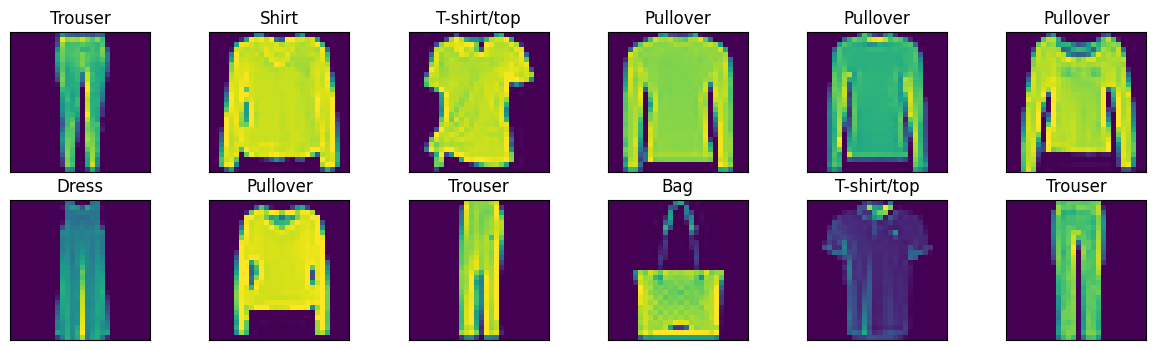

In [8]:
# Display image
def image_show(image):
    image = image / 2 + 0.5  # unnormalize
    npimg = image.numpy()  # convert from tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose dimensions


images, labels = next(iter(train_loader))  # get the first batch

# show images with labels
fig = plt.figure(figsize=(15, 4))
plot_size = 12

for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size // 2, idx + 1, xticks=[], yticks=[])
    image_show(images[idx])
    ax.set_title(get_class_name(int(labels[idx])))

### Create PyTorch model with MobileNetV3 architecture

Inspect the MobileNetV3 structure

In [9]:
import torchvision.models as models

mobilenet_v3_model = models.mobilenet_v3_small(pretrained=True)
print(mobilenet_v3_model)

d:\MyGithub\ML_PyTorch_Experiments\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MyGithub\ML_PyTorch_Experiments\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\Jari/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100.0%

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

MobileNetV3 has 1000 output classes, we need only 10 for Fashion-MNIST

In [10]:
import torch.nn.functional as F
import torchvision.models as models
from torch import nn


# Define a model class that extends the nn.Module class
class MobileNetV3(nn.Module):
    def __init__(self):
        super(MobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 (Small) architecture
        self.model = models.mobilenet_v3_small(pretrained=True)

        # Replace the last fully-connected layer with a new one of the right size
        self.model.classifier[3] = nn.Linear(1024, 10)

        # Freeze all the weights of the network except for the last fully-connected layer
        self.freeze()

    def forward(self, x):
        # Convert 1x28x28 input tensor to 3x28x28 tensor, to convert it to a color image
        x = x.repeat(1, 3, 1, 1)

        # Resize the input to 224x224, since MobileNetV3 (Small) expects images of that size
        if x.shape[2:] != (224, 224):
            x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)

        # Forward pass
        return self.model(x)

    def freeze(self):
        # Freeze all the weights of the network except for the last fully-connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the final layer
        for param in self.model.classifier[3].parameters():
            param.requires_grad = True

    def unfreeze(self):
        # Unfreeze all the weights of the network
        for param in self.model.parameters():
            param.requires_grad = True


# Create an instance of the MobileNetV3 model
model = MobileNetV3()
print(model)

MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

d:\MyGithub\ML_PyTorch_Experiments\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MyGithub\ML_PyTorch_Experiments\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train the model with Fashion-MNIST dataset

In [11]:
# Set the device as GPU, MPS, or CPU according to availability
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


In [12]:
import torch.nn as nn

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# Create a PyTorch training loop
model = model.to(device)  # Move the model weights to the device

epochs = 1
for epoch in range(epochs):
    for batch_num, (images, labels) in enumerate(train_loader):
        # Move tensors to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss and perform backpropagation
        loss = loss_function(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Print the loss for every 100th iteration
        if (batch_num) % 100 == 0:
            print(
                "Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}".format(
                    epoch + 1, epochs, batch_num + 1, len(train_loader), loss.item()
                )
            )

Epoch [1/1], Batch [1/938], Loss: 2.3976
Epoch [1/1], Batch [101/938], Loss: 0.7203
Epoch [1/1], Batch [201/938], Loss: 0.4085
Epoch [1/1], Batch [301/938], Loss: 0.4091
Epoch [1/1], Batch [401/938], Loss: 0.3644
Epoch [1/1], Batch [501/938], Loss: 0.4550
Epoch [1/1], Batch [601/938], Loss: 0.4291
Epoch [1/1], Batch [701/938], Loss: 0.4412
Epoch [1/1], Batch [801/938], Loss: 0.5177
Epoch [1/1], Batch [901/938], Loss: 0.3907


### Evaluate Model with Test Set

In [13]:
# Print the loss and accuracy on the test set
correct = 0
total = 0
loss = 0

for images, labels in test_loader:
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss += loss_function(outputs, labels) 

    # torch.max return both max and argmax. We get the argmax here.
    _, predicted = torch.max(outputs.data, 1)

    # Compute the accuracy
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Test Accuracy of the model on the test images: {} %".format(100 * correct / total))

print("Test Loss of the model on the test images: {}".format(loss))

Test Accuracy of the model on the test images: 85.16 %
Test Loss of the model on the test images: 64.23084259033203


Check a few examples

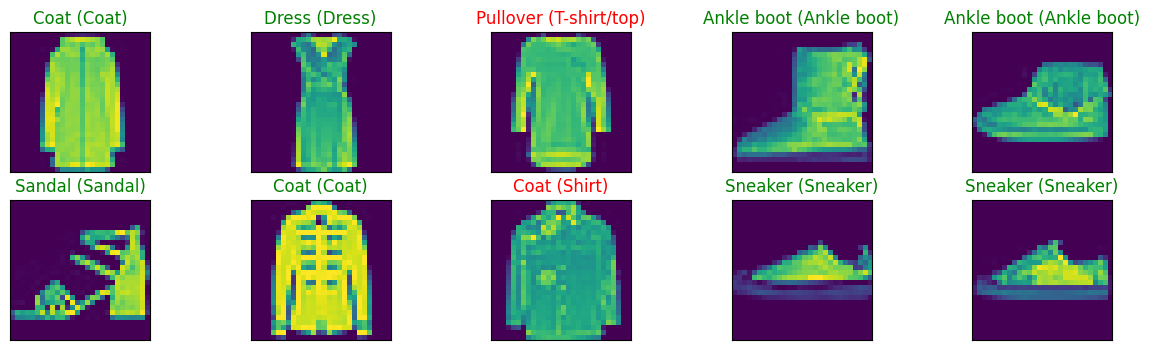

In [14]:
# Get the first batch of images and labels
images, labels = next(iter(test_loader))

# Move tensors to the configured device
images = images.to(device)
labels = labels.to(device)

# Forward pass
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

# Plot the images with labels, at most 10
fig = plt.figure(figsize=(15, 4))

for idx in np.arange(min(10, len(images))):
    ax = fig.add_subplot(2, 10 // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images.cpu()[idx]))
    ax.set_title(
        "{} ({})".format(get_class_name(predicted[idx]), get_class_name(labels[idx])),
        color=("green" if predicted[idx] == labels[idx] else "red"),
    )